<a href="https://colab.research.google.com/github/tejaswishetty17/Agentic-AI/blob/main/Calling_Agents_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q langchain langchain_openai langchain_community langgraph langchain-core

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching about Agentic AI?", name = "Model")]
messages.append(HumanMessage(content=f"Yes, that's right.", name = "User"))
messages.append(AIMessage(content=f"Great, What would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the working of Agentic AI", name="User"))

for m in messages:
  m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching about Agentic AI?
================================ Human Message =================================
Name: User

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, What would you like to learn about.
================================ Human Message =================================
Name: User

I want to learn about the working of Agentic AI


In [3]:
import os
os.environ["OPENAI_API_KEY"] = "<YOUR API KEY>"

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-4o-mini")
result = llm.invoke(messages)

In [5]:
result.content

'Agentic AI, often referred to as "autonomous AI," is designed to perform tasks and make decisions without human intervention. Here are some key aspects of how Agentic AI works:\n\n1. **Autonomy**: Agentic AI systems are capable of making decisions on their own based on the data they have access to. They can analyze situations, weigh options, and choose actions without needing to consult a human operator.\n\n2. **Learning and Adaptation**: These systems often use machine learning algorithms to improve their performance over time. They learn from past experiences, adapt to new information, and refine their strategies based on outcomes.\n\n3. **Goal-Driven Behavior**: Agentic AI is typically programmed with specific goals or objectives. It prioritizes actions that best align with achieving these goals. This can involve optimizing for efficiency, effectiveness, or other criteria defined by the developers.\n\n4. **Sensor Fusion**: Many Agentic AI systems use sensor data to understand their

In [6]:
result.response_metadata

{'token_usage': {'completion_tokens': 490,
  'prompt_tokens': 64,
  'total_tokens': 554,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_62a23a81ef',
 'id': 'chatcmpl-BdaMg89WZM9r0DPZ6jNuwSdeTrpyO',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

#createing a tool using langchain.tools

In [37]:
from langchain.tools import tool

@tool  #register as a tool
def multiply(a: int, b: int)-> int:
  """Multiply a and b.
  Args:
    a: first int
    b: second int
  """ #this is important for the llm to judge if it has to do a tool call when the tool is registered.
  return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g. "What is 2 multiplied by 3" - we see a tool call returned.

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

{'arguments':'{"a":2, "b":3}', 'name':'multiply'}

In [8]:
result = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="User")])

In [9]:
result.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_flz4XF5KrlDeLLg6VfACXOFe',
  'type': 'tool_call'}]

#Using Message as State

with these foundations in place, we can now use `messages` in our graph state.
Let's define our state, `MessageState`, as a `TypeDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above(eg. `HumanMessage`, etc).


In [11]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessageState(TypedDict):
  messages: list[AnyMessage]

Since having a list of messages in graph state is so common, LangGraph has a pre-build `MessagesState`!

`MessagesState` is defined:


*   with a pre-build single `messages` key
*   This is a list of `AnyMessage` objects
*   It uses the `add_messages` reducer

We'll usually use `MessageState` becasue it is less verbose than defining a custom `TypeDict`, as shown above.




In [29]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
  #add any keys needed beyond this messages, which is pre-built
  pass

#Our Graph

now, lets use `MessageState` with a graph

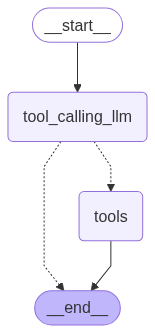

In [34]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

#Node
def tool_calling_llm(state: MessagesState):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

#Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message from tool_calling_llm is a tool call -> tools_condition routes to tools node
    # if the latest message from tool_calling_llm is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", END)
graph = builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))

if we pass in a `user question`, the LLM responds without any toold calls.

In [35]:
messages = graph.invoke({"messages":HumanMessage(content="What is the use of LLM?")})

for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

What is the use of LLM?
================================== Ai Message ==================================

Large Language Models (LLMs) have a variety of uses across different fields and applications. Here are some of the primary uses:

1. **Text Generation**: LLMs can generate human-like text, making them useful for creative writing, content creation, and storytelling.

2. **Natural Language Understanding**: They can understand and interpret human language, which is essential for applications like chatbots, virtual assistants, and customer support systems.

3. **Translation**: LLMs can translate text between languages, helping in breaking language barriers and enhancing communication.

4. **Summarization**: They can summarize long texts into concise versions, aiding in quick information retrieval and understanding.

5. **Question Answering**: LLMs can respond to queries by providing relevant information, 

The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool

In [36]:
messages = graph.invoke({"messages":HumanMessage(content="Multiply 300 and 80")})

for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Multiply 300 and 80
================================== Ai Message ==================================
Tool Calls:
  multiply (call_r6M2S2k5PkytKtam7k9CiRWM)
 Call ID: call_r6M2S2k5PkytKtam7k9CiRWM
  Args:
    a: 300
    b: 80
================================= Tool Message =================================
Name: multiply

24000
